## Group Project Exploratory Notebook 2

Import required libraries:

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import os
import plotly.offline as po
import plotly.graph_objs as pg
from functools import reduce
from scipy.stats import zscore
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Load Food Environment Atlas from usda. The Excel file contains multiple spreadsheets with the categories health, insecurity, socioeconomic, stores, local, access, assistance. 

In [21]:
health = pd.read_excel('usda_health.xlsx')
insecurity = pd.read_excel('usda_insecurity.xlsx')
socioeconomic = pd.read_excel('usda_socioeconomic.xlsx')
stores = pd.read_excel('usda_stores.xlsx')
access = pd.read_excel('usda_access.xlsx')
assistance = pd.read_excel('usda_assistance.xlsx')

Retain only the variables of interest from each data frame as well as FIPS and State for merging and other data processing. 

In [22]:
health_df = health[["FIPS", "State", "PCT_OBESE_ADULTS22"]]

In [23]:
insecurity_df = insecurity[["FIPS", "State", 
                "FOODINSEC_21_23", "VLFOODSEC_21_23"]]

In [24]:
socio_df = socioeconomic[[
    "FIPS",
    "State",
    "MEDHHINC21",
    "POVRATE21",
    "PCT_65OLDER20"
]]

In [25]:
stores_df = stores[[
    "FIPS",
    "State",
    "GROCPTH20",
    "SUPERCPTH20",
    "CONVSPTH20",
    "SPECSPTH20",
    "SNAPSPTH23",
    "WICSPTH22"
]]

In [26]:
access_df = access[['FIPS', 'State', 'PCT_LACCESS_LOWI19', 'PCT_LACCESS_HHNV19']]


In [27]:
assistance_df= assistance[['FIPS', 'State', 'REDEMP_SNAPS23', 'FOOD_BANKS21']]

Combine the data frames based on FIPS and State. 

In [28]:
dfs = [health_df, insecurity_df, socio_df, stores_df, access_df, assistance_df]

In [29]:
df = reduce(lambda left, right: pd.merge(left, right, on=['FIPS', 'State'], how='left'), dfs)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3144 entries, 0 to 3143
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   FIPS                3144 non-null   int64  
 1   State               3144 non-null   object 
 2   PCT_OBESE_ADULTS22  3144 non-null   float64
 3   FOODINSEC_21_23     3143 non-null   float64
 4   VLFOODSEC_21_23     3143 non-null   float64
 5   MEDHHINC21          3144 non-null   int64  
 6   POVRATE21           3144 non-null   float64
 7   PCT_65OLDER20       3144 non-null   float64
 8   GROCPTH20           3144 non-null   float64
 9   SUPERCPTH20         3144 non-null   float64
 10  CONVSPTH20          3144 non-null   float64
 11  SPECSPTH20          3144 non-null   float64
 12  SNAPSPTH23          3144 non-null   float64
 13  WICSPTH22           3144 non-null   float64
 14  PCT_LACCESS_LOWI19  3144 non-null   float64
 15  PCT_LACCESS_HHNV19  3144 non-null   float64
 16  REDEMP

Rename each variable into simpler names. Then view basic summary statistics of variables.

In [31]:
rename = {
    "PCT_LACCESS_LOWI19": "low_income_access",
    "PCT_LACCESS_HHNV19": "no_car_access",
    "GROCPTH20": "grocery_stores",
    "SUPERCPTH20": "supercenters",
    "CONVSPTH20": "convenience_stores",
    "SPECSPTH20": "specialized_food_stores",
    "SNAPSPTH23": "snap_stores",
    "WICSPTH22": "wic_stores",
    "REDEMP_SNAPS23": "snap_redemptions",
    "FOOD_BANKS21": "food_banks",
    "FOODINSEC_21_23": "food_insecurity_rate",
    "VLFOODSEC_21_23": "very_low_food_security_rate",
    "PCT_OBESE_ADULTS22": "obesity",
    "PCT_65OLDER20": "sixtyfive_plus",
    "MEDHHINC21": "median_income",
    "POVRATE21": "poverty"
}

df = df.rename(columns=rename)


In [32]:
df.describe()

,FIPS,obesity,food_insecurity_rate,very_low_food_security_rate,median_income,poverty,sixtyfive_plus,grocery_stores,supercenters,convenience_stores,specialized_food_stores,snap_stores,wic_stores,low_income_access,no_car_access,snap_redemptions,food_banks
count,3144.000000,3144.000000,3143.000000,3143.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3144.000000,3.144000e+03,3144.000000
mean,30365.634542,32.385337,-10.188387,-17.728667,58898.131361,8.593257,17.308879,-2893.598863,-7851.907907,-905.522436,-6484.336227,-94.034353,-368.370915,-0.750239,-6.058792,2.671751e+06,-9.101145
std,15174.497197,159.173921,448.546831,448.160358,15359.949393,238.989659,158.941087,4534.885278,4106.222116,2870.374284,4774.377370,968.912228,1883.503846,298.128727,297.887205,1.060653e+07,297.778608
min,1001.000000,-8888.000000,-8888.000000,-8888.000000,-9999.000000,-9999.000000,-8888.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9.999000e+03,-9999.000000
25%,18174.500000,33.400000,10.600000,4.000000,49002.000000,10.600000,17.240447,-9999.000000,-9999.000000,0.353378,-9999.000000,0.757041,0.099514,3.655029,1.607701,1.438900e+05,0.000000
50%,29174.000000,35.500000,12.300000,4.700000,56629.000000,13.600000,19.784419,0.141789,-9999.000000,0.492827,-9999.000000,0.961609,0.146350,6.687809,2.540787,5.238866e+05,0.000000
75%,45079.500000,37.700000,13.100000,5.800000,65683.750000,17.525000,22.626233,0.216868,-9999.000000,0.666688,0.051036,1.219983,0.222748,10.872572,3.880950,1.650108e+06,0.000000
max,56045.000000,41.000000,18.900000,7.000000,153716.000000,43.900000,58.859979,2.335357,0.180072,4.441977,0.635324,11.011011,3.546099,62.599918,54.574402,3.380466e+08,2.000000


In the row for minimum values, there are values -8888, -9999. Per the data source, -9999, -8888, and NaN values are used for missing values. The first step to address this is replacing -9999 and -8888 with NaN. 

In [33]:
df.replace([-9999, -8888], np.nan, inplace=True)

In [34]:
df.describe()

,FIPS,obesity,food_insecurity_rate,very_low_food_security_rate,median_income,poverty,sixtyfive_plus,grocery_stores,supercenters,convenience_stores,specialized_food_stores,snap_stores,wic_stores,low_income_access,no_car_access,snap_redemptions,food_banks
count,3144.000000,3143.000000,3135.000000,3135.000000,3142.000000,3142.000000,3143.000000,2234.000000,675.000000,2859.000000,1105.000000,3114.000000,3028.000000,3141.000000,3141.000000,2.958000e+03,3141.000000
mean,30365.634542,35.223513,12.466316,4.906794,58941.633355,14.609866,20.142257,0.225683,0.031914,0.574138,0.087695,1.032432,0.203053,8.445479,3.131856,2.840380e+06,0.086597
std,15174.497197,3.266036,2.465886,1.060569,15267.686038,5.663115,4.704975,0.178522,0.014662,0.278875,0.067549,0.444946,0.189634,7.430106,2.974417,1.091302e+07,0.286893
min,1001.000000,24.300000,7.400000,3.200000,25653.000000,2.900000,4.798745,0.037616,0.003748,0.129240,0.015244,0.188986,0.010869,0.000000,0.000000,4.856338e+03,0.000000
25%,18174.500000,33.400000,10.600000,4.000000,49016.250000,10.600000,17.242008,0.134743,0.023211,0.395288,0.049351,0.764106,0.104529,3.669639,1.612652,1.935215e+05,0.000000
50%,29174.000000,35.500000,12.300000,4.700000,56634.000000,13.600000,19.785063,0.179095,0.029500,0.521584,0.069428,0.966103,0.150190,6.696394,2.541467,6.016242e+05,0.000000
75%,45079.500000,37.700000,13.100000,5.800000,65687.250000,17.575000,22.627022,0.256055,0.037449,0.690926,0.103413,1.222158,0.227261,10.882041,3.881178,1.781044e+06,0.000000
max,56045.000000,41.000000,18.900000,7.000000,153716.000000,43.900000,58.859979,2.335357,0.180072,4.441977,0.635324,11.011011,3.546099,62.599918,54.574402,3.380466e+08,2.000000


The values -8888 and -9999 have been replaced with NaN. The next step is to perform imputation to replace the missing values with mean values. This project chose to do mean imputation at the state level.

In [35]:
impute = [c for c in df.columns if c not in ['FIPS', 'State'] and pd.api.types.is_numeric_dtype(df[c])]

In [36]:
df[impute] = df.groupby('State')[impute].transform(lambda x: x.fillna(x.mean()))

In [37]:
df.info()
df.describe().T
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3144 entries, 0 to 3143
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   FIPS                         3144 non-null   int64  
 1   State                        3144 non-null   object 
 2   obesity                      3144 non-null   float64
 3   food_insecurity_rate         3136 non-null   float64
 4   very_low_food_security_rate  3136 non-null   float64
 5   median_income                3144 non-null   float64
 6   poverty                      3144 non-null   float64
 7   sixtyfive_plus               3144 non-null   float64
 8   grocery_stores               3144 non-null   float64
 9   supercenters                 3144 non-null   float64
 10  convenience_stores           3144 non-null   float64
 11  specialized_food_stores      3144 non-null   float64
 12  snap_stores                  3136 non-null   float64
 13  wic_stores        

FIPS                           0
State                          0
obesity                        0
food_insecurity_rate           8
very_low_food_security_rate    8
median_income                  0
poverty                        0
sixtyfive_plus                 0
grocery_stores                 0
supercenters                   0
convenience_stores             0
specialized_food_stores        0
snap_stores                    8
wic_stores                     8
low_income_access              0
no_car_access                  0
snap_redemptions               0
food_banks                     0
dtype: int64

Due to performing imputation at the state level, some NaN values were missed and remain in the data. Beause they account for a small percent of the data, the remaining rows with missing values will be dropped using the code below.

In [39]:
df = df.dropna(subset=[
    "food_insecurity_rate",
    "very_low_food_security_rate",
    "snap_stores",
    "wic_stores"
])

In [40]:
df.info()
df.describe().T
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 3136 entries, 0 to 3143
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   FIPS                         3136 non-null   int64  
 1   State                        3136 non-null   object 
 2   obesity                      3136 non-null   float64
 3   food_insecurity_rate         3136 non-null   float64
 4   very_low_food_security_rate  3136 non-null   float64
 5   median_income                3136 non-null   float64
 6   poverty                      3136 non-null   float64
 7   sixtyfive_plus               3136 non-null   float64
 8   grocery_stores               3136 non-null   float64
 9   supercenters                 3136 non-null   float64
 10  convenience_stores           3136 non-null   float64
 11  specialized_food_stores      3136 non-null   float64
 12  snap_stores                  3136 non-null   float64
 13  wic_stores             

FIPS                           0
State                          0
obesity                        0
food_insecurity_rate           0
very_low_food_security_rate    0
median_income                  0
poverty                        0
sixtyfive_plus                 0
grocery_stores                 0
supercenters                   0
convenience_stores             0
specialized_food_stores        0
snap_stores                    0
wic_stores                     0
low_income_access              0
no_car_access                  0
snap_redemptions               0
food_banks                     0
dtype: int64

The output above confirms there are now no missing (NaN) values. 

The project wanted to capture as many measurements as possible regarding grocery store access. However, having this number of measurements of grocery stores presents challenges. Two new variables, total_stores and assistance_stores, were generated to consolidate the grocery store variables.

In [41]:
df["total_stores"] = (df["grocery_stores"]+ df["supercenters"]+ df["convenience_stores"]+ df["specialized_food_stores"])

df["assistance_stores"] = (df["snap_stores"] + df["wic_stores"])


C:\Users\emily\AppData\Local\Temp\ipykernel_17500\896917032.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\emily\AppData\Local\Temp\ipykernel_17500\896917032.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Confirm the new variables successfully integrated into the dataset. Note that the count remains 3115.

In [42]:
df[["total_stores", "assistance_stores"]].describe()

,total_stores,assistance_stores
count,3136.000000,3136.000000
mean,0.928192,1.237087
std,0.352886,0.550201
min,0.253729,0.264580
25%,0.696499,0.901256
50%,0.863739,1.147696
75%,1.075678,1.451931
max,4.846510,12.012012


At this stage, the different grocery store measures as well as FIPS and State are no longer needed in the dataset. These can be dropped. The code `df.columns` will confirm the remaining columns we want to use. 

In [43]:
store_cols_to_drop = [
    "grocery_stores",
    "supercenters",
    "convenience_stores",
    "specialized_food_stores",
    "snap_stores",
    "wic_stores",
    "State",
    "FIPS"
]

In [44]:
df = df.drop(columns=store_cols_to_drop)

In [45]:
df.columns

Index(['obesity', 'food_insecurity_rate', 'very_low_food_security_rate',
       'median_income', 'poverty', 'sixtyfive_plus', 'low_income_access',
       'no_car_access', 'snap_redemptions', 'food_banks', 'total_stores',
       'assistance_stores'],
      dtype='object')

### Heatmap for initial exploration

A heatmap will be used to perform initial exploration of the correlation between each predictor and obesity. This begins with computing the correlation matric and then plotting the heatmap.

In [46]:
corr_matrix = df.corr()

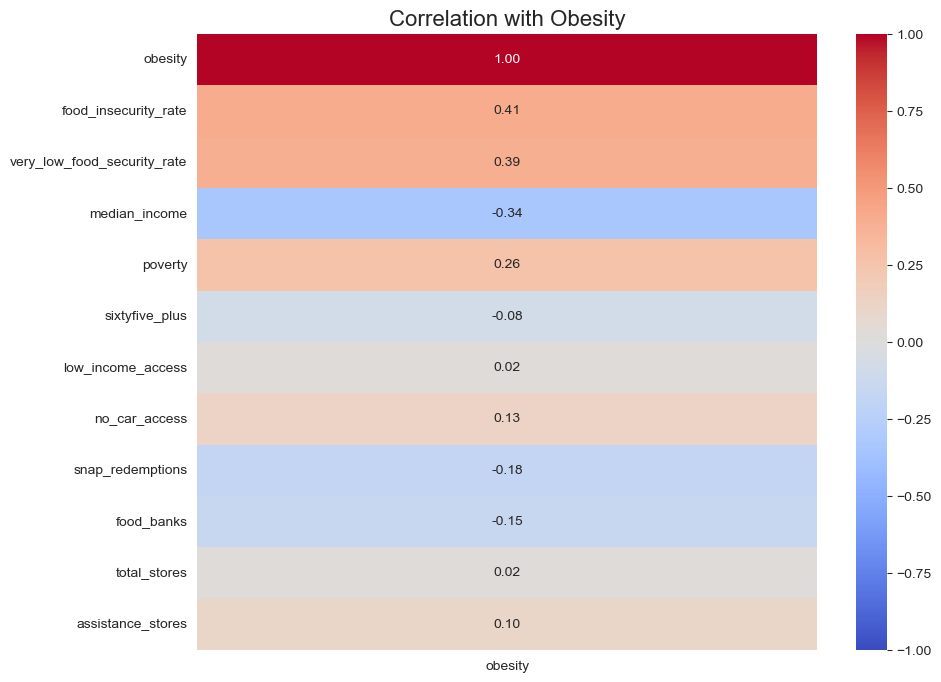

In [47]:
plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix[["obesity"]],  
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    vmin=-1, vmax=1
)
plt.title("Correlation with Obesity", fontsize=16)
plt.show()

### Investigating each variable for potential needed transformations

The project then explored variables to see if transformation were needed. Because of the number of variables, a multivariable approach was used.

Check for skewness.
- Skew = 0 indicates perfectly symmetric distribution
- Skew >0 indicates right-skewed (long tail to the right)
- Skew <0 indicates left-skewed (long tail to the left)

In [48]:
predictors = ['food_insecurity_rate', 'very_low_food_security_rate', 'median_income', 'poverty',
              'sixtyfive_plus', 'low_income_access', 'no_car_access', 'snap_redemptions',
              'food_banks', 'total_stores', 'assistance_stores']

In [49]:
skewness = df[predictors].skew().sort_values(ascending=False)
print("Skewness of predictors:\n", skewness)

Skewness of predictors:
 snap_redemptions               16.029124
no_car_access                   7.316837
assistance_stores               4.354584
food_banks                      3.162139
low_income_access               2.321869
total_stores                    2.297194
median_income                   1.364974
poverty                         1.156337
food_insecurity_rate            0.685911
sixtyfive_plus                  0.668971
very_low_food_security_rate     0.124914
dtype: float64


The output tells us:

Highly skewed
- snap_redemptions is 16.09. This means either extreme outliers and/or very right skewed
- no car access is 7.31. This is highly skewed
- assistance_stores in 4.37, highly skewed
- food_banks is 3.19. This is highly skewed

This could mean a small number of counties or states in the dataset have very highly values. Will explore log transformation of the variables.

Moderately skewed
- low_income_access 2.32
- total_stores 2.29
- median_income 1.35
- poverty 1.16

These values are still skewed but not as severe as noted above. Will explore log transformation if the scatterplots vs obesity show curvature. 

Low skew
- food_insecurity_rate 0.68
- sixtyfive_plus 0.67
- very_low_food_security_rate 0.12

These distributions appear fairly symmetric and can be left as is for regression.

Plot histograms to visualize distributions

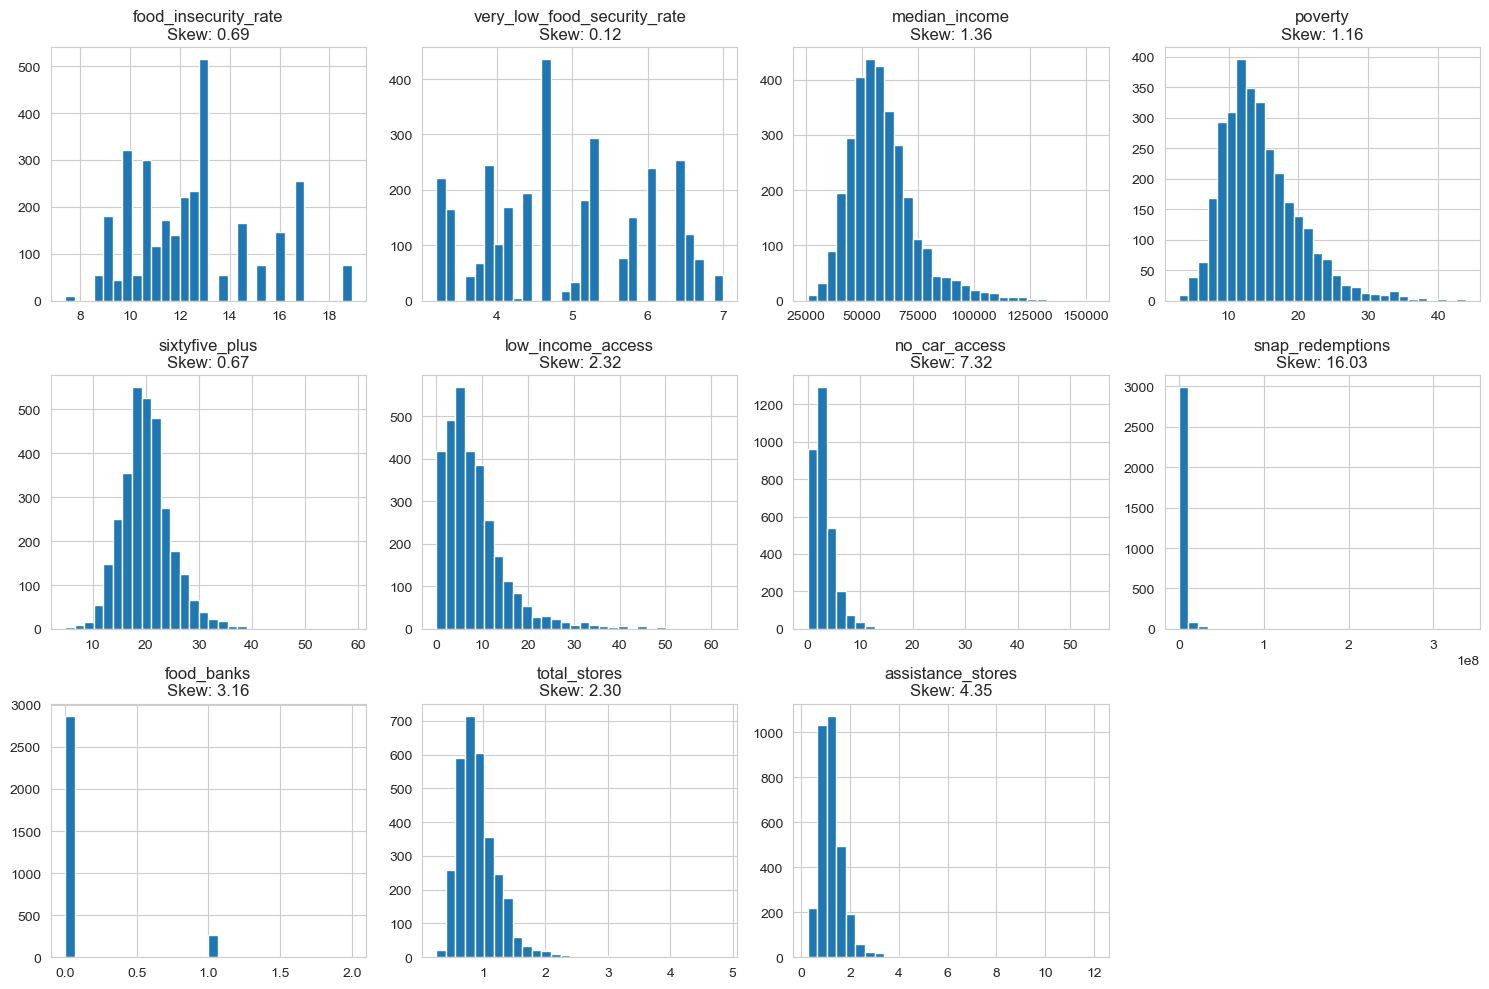

In [50]:
plt.figure(figsize=(15,10))
for i, col in enumerate(predictors, 1):
    plt.subplot(3, 4, i)
    df[col].hist(bins=30)
    plt.title(f"{col}\nSkew: {skewness[col]:.2f}")
plt.tight_layout()
plt.show()

In the distribution above it appears that food banks are distributed as either there is a food bank or there is not a food bank. This variable will be treated as a categorical variable.

Scatterplots vs outcomes to check for linearity

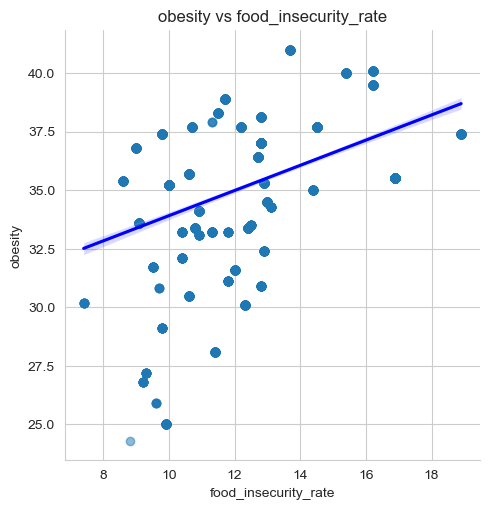

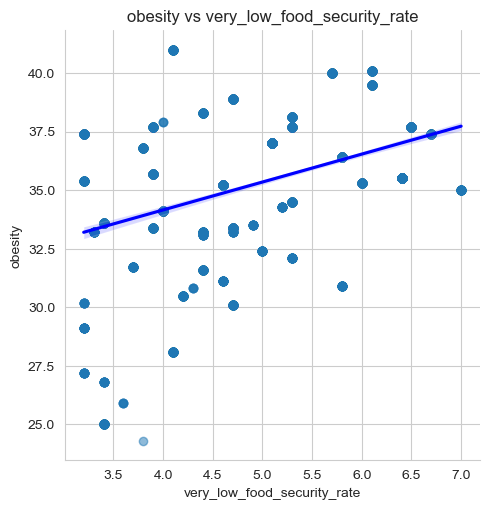

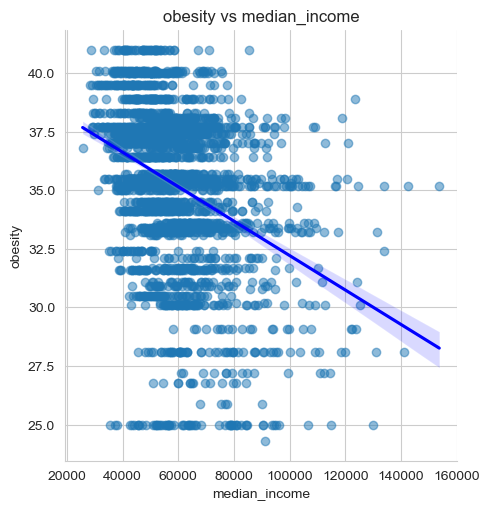

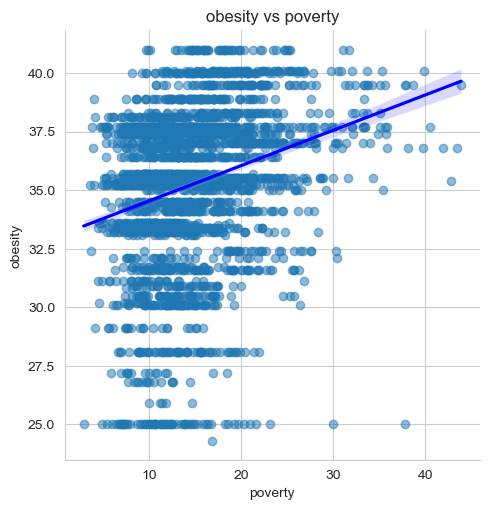

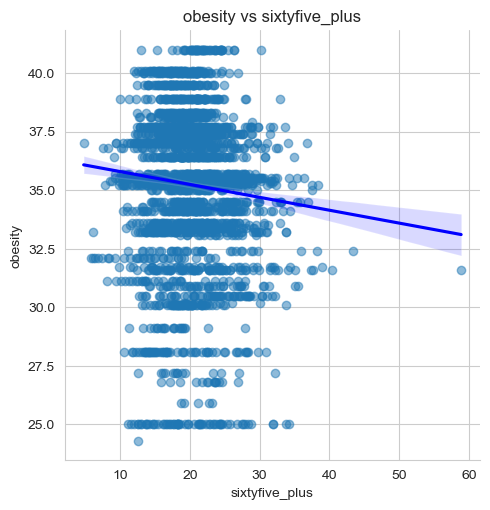

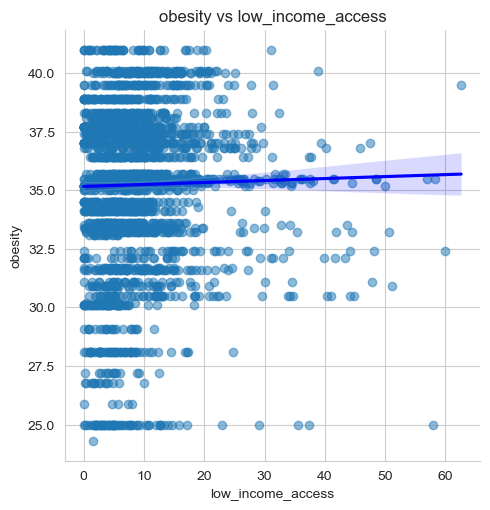

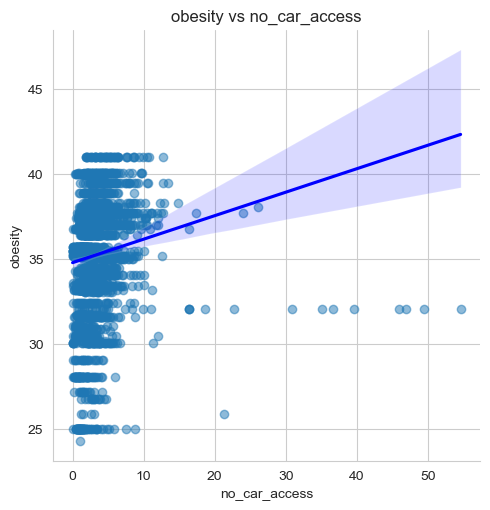

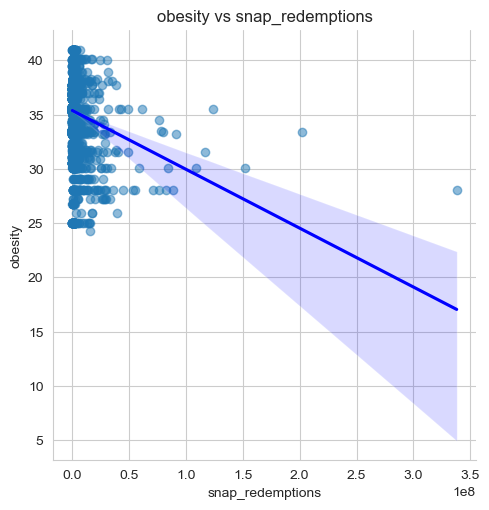

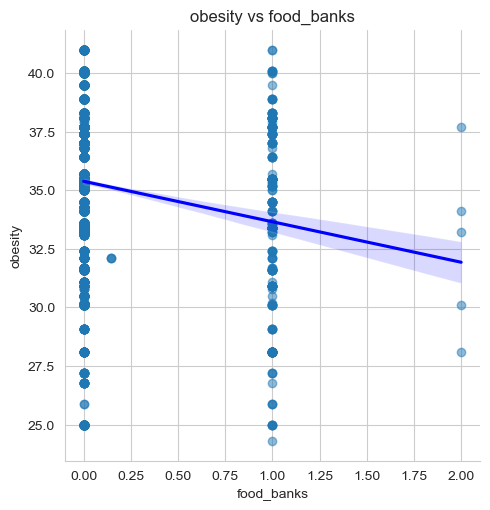

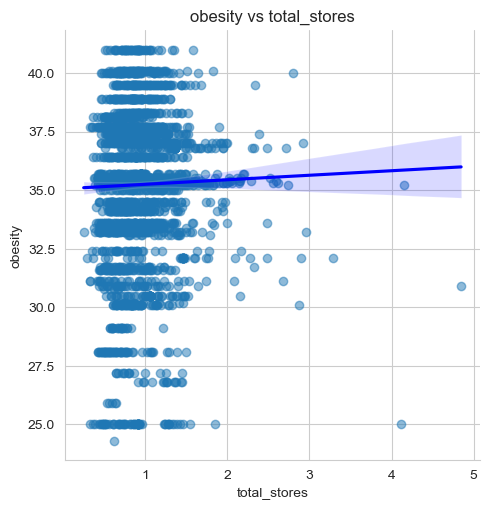

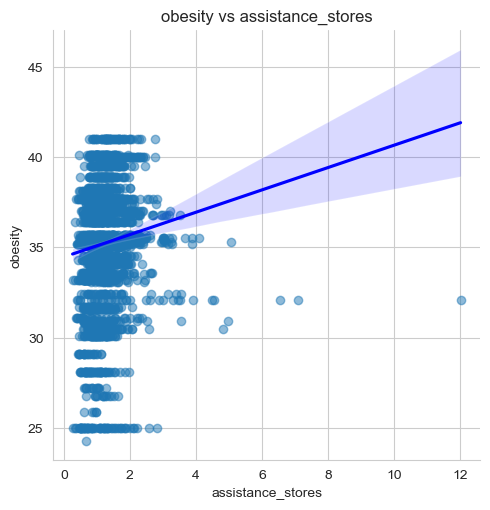

In [51]:
for outcome in ['obesity']:
    for col in predictors:
        sns.lmplot(data=df, x=col, y=outcome, scatter_kws={"alpha":0.5}, line_kws={"color":"blue"})
        plt.title(f"{outcome} vs {col}")
plt.show()

Summary:

We have taken a preliminary look at predictors by measuring their skewness and then visualizing it via plots. We have identified some potential transformations in the categories below.

Highly skewed and need to investigate transformations
- snap_redemptions (16.09) 
- no_car_access (7.31)
- assistance_stores (4.37)

Moderately skewed, transformation could help
- low_income_access (2.32)
- total_stores (2.29)
- median_income (1.35)
- poverty (1.16)

Change to categorical variable:
food_banks 

### Investigate snap redemptions

In [52]:
model_snap_redemptions = smf.ols(formula="obesity ~ snap_redemptions", data=df).fit()
print(model_snap_redemptions.summary())

                            OLS Regression Results                            
Dep. Variable:                obesity   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     100.5
Date:                Mon, 10 Nov 2025   Prob (F-statistic):           2.67e-23
Time:                        14:46:09   Log-Likelihood:                -8107.4
No. Observations:                3136   AIC:                         1.622e+04
Df Residuals:                    3134   BIC:                         1.623e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           35.3826      0.059  

The output above confirms what was determined with the original skewness test, notably the low R-squared value 0.29. 

Look at mean absolute error:

In [53]:
y_hat1= model_snap_redemptions.predict()

In [54]:
np.sqrt(mean_squared_error(df["obesity"], y_hat1)).round(3)

np.float64(3.21)

In [55]:
mean_absolute_error(df["obesity"], y_hat1)

2.4277681042274195

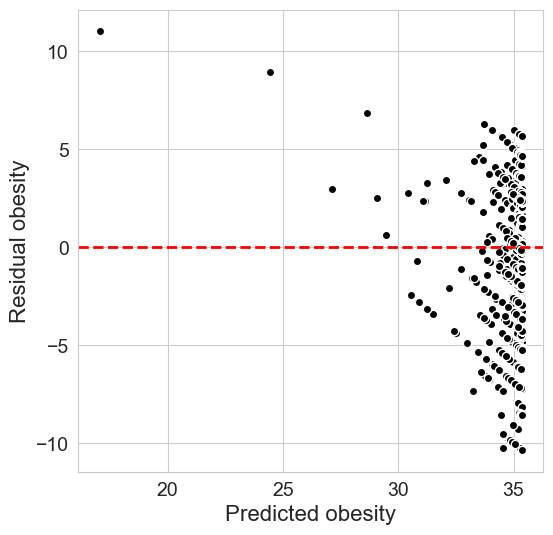

In [56]:
plt.figure(figsize=(6,6))

plt.plot(y_hat1, model_snap_redemptions.resid, "ko", mec="w")
plt.axhline(0, color="r", linestyle="dashed", lw=2)

plt.xlabel("Predicted obesity", fontsize=16)
plt.ylabel("Residual obesity", fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

The residuals are congregated to the right. Will apply log transformation.

In [57]:
df['snap_redemptions_log'] = np.log1p(df['snap_redemptions'])

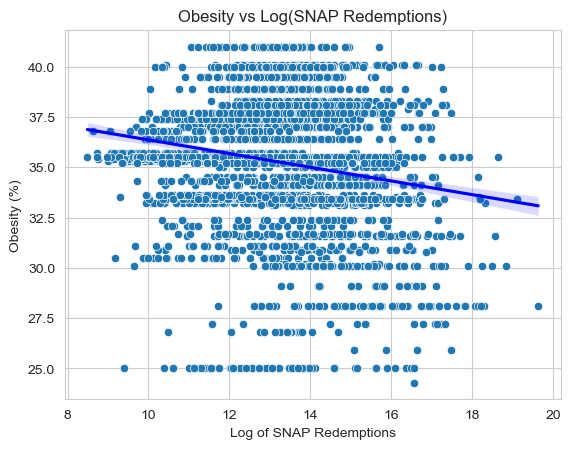

In [58]:
sns.scatterplot(x='snap_redemptions_log', y='obesity', data=df)
sns.regplot(x='snap_redemptions_log', y='obesity', data=df, scatter=False, color='blue')
plt.xlabel("Log of SNAP Redemptions")
plt.ylabel("Obesity (%)")
plt.title("Obesity vs Log(SNAP Redemptions)")
plt.show()

In [59]:
model_snap_redemptions_log = smf.ols(formula="obesity ~ snap_redemptions_log", data=df).fit()
print(model_snap_redemptions_log.summary())

                            OLS Regression Results                            
Dep. Variable:                obesity   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     99.43
Date:                Mon, 10 Nov 2025   Prob (F-statistic):           4.47e-23
Time:                        14:46:10   Log-Likelihood:                -8107.9
No. Observations:                3136   AIC:                         1.622e+04
Df Residuals:                    3134   BIC:                         1.623e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               39.7617 

In [60]:
y_hat2= model_snap_redemptions_log.predict()

In [61]:
np.sqrt(mean_squared_error(df["obesity"], y_hat2)).round(3)

np.float64(3.211)

In [62]:
mean_absolute_error(df["obesity"], y_hat2)

2.4473719732197825

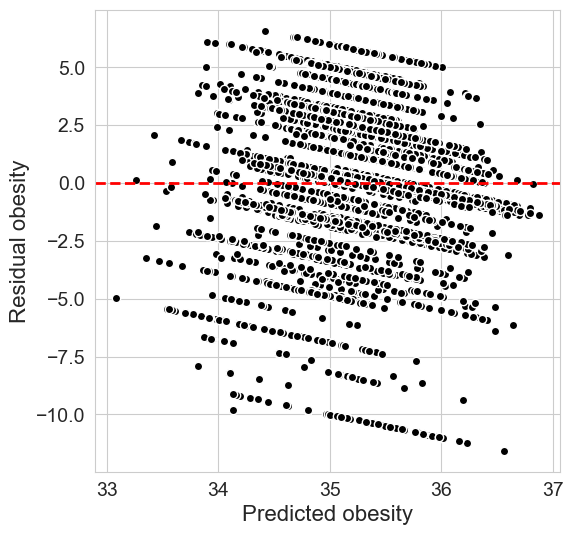

In [63]:
plt.figure(figsize=(6,6))

plt.plot(y_hat2, model_snap_redemptions_log.resid, "ko", mec="w")
plt.axhline(0, color="r", linestyle="dashed", lw=2)

plt.xlabel("Predicted obesity", fontsize=16)
plt.ylabel("Residual obesity", fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

After applying the log transformation, the residuals are more scattered compared to before. There is still some clustering, but the introduction of more variables in the multivariate model may improve this. 

# Fit the model (code placeholder, not ready yet)

In [64]:
model = smf.ols("obesity ~ food_insecurity_rate + very_low_food_security_rate + median_income+ poverty + sixtyfive_plus + low_income_access + no_car_access + snap_redemptions + food_banks + total_stores + assistance_stores", data = df).fit()

In [65]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                obesity   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     106.9
Date:                Mon, 10 Nov 2025   Prob (F-statistic):          2.51e-207
Time:                        14:46:10   Log-Likelihood:                -7656.0
No. Observations:                3136   AIC:                         1.534e+04
Df Residuals:                    3124   BIC:                         1.541e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         